In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

import yfinance as yf
from yahoo_fin import stock_info


ticker = 'BRK'
historical_stock_prices = (yf.Ticker(ticker)).history(period = 'max')
historical_stock_prices.to_csv('../../current/'+ticker+ '.csv')

data = pd.read_csv('../../current/'+ticker+'.csv')

# data

<h2>Preprocessing</h2>

In [82]:
data = data[['Date', 'Close']]
# data

In [83]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device("mps")

In [84]:
data['Date'] = pd.to_datetime(data['Date'])

# plt.plot(data['Date'], data['Close'])

/var/folders/9q/z460vfh90fs5gczm84vpgyg80000gp/T/ipykernel_14335/3845445604.py:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise a warning unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['Date'] = pd.to_datetime(data['Date'])


In [85]:
from copy import deepcopy as dc
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 30
shifted_df = prepare_dataframe_for_lstm(data, lookback)
# shifted_df

In [86]:
shifted_df_as_np = shifted_df.to_numpy()

# shifted_df_as_np

In [87]:
# shifted_df_as_np.shape

In [88]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

# shifted_df_as_np

In [89]:
# Split into x input, and y output
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

# X.shape, y.shape

In [90]:
X = dc(np.flip(X, axis=1))
# X

<h2>Output</h2>

In [91]:
split_index = int(len(X) * 0.95)
split_index
lookback = 30

In [92]:
# Split 95% into train, 5% into test

X_test = X[split_index:]
y_test = y[split_index:]


In [93]:

X_test = X_test.reshape((-1, lookback, 1))
y_test = y_test.reshape((-1, 1))


In [94]:
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_test.shape, y_test.shape

(torch.Size([286, 30, 1]), torch.Size([286, 1]))

In [95]:
# outmodel = LSTM(30, 1, 64, 16, 1)
from  Modules.model import LSTM
outmodel = torch.load('../../forecast_final.pt').to(device)
outmodel.eval()

LSTM(
  (conv1d): Conv1d(30, 1, kernel_size=(1,), stride=(2,))
  (init_linear): Linear(in_features=1, out_features=1, bias=True)
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sequential): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): ReLU()
    (2): LSTM(1, 64, num_layers=2, batch_first=True, bidirectional=True)
  )
)

In [96]:
test_predictions = outmodel(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([0.10356507, 0.10367223, 0.10366662, 0.1033495 , 0.10174086,
       0.10055961, 0.1014524 , 0.10100133, 0.10099385, 0.10098949,
       0.10098638, 0.10098762, 0.10003502, 0.09920577, 0.10027115,
       0.1003079 , 0.10031974, 0.10000449, 0.10014716, 0.09951791,
       0.09823012, 0.09943567, 0.0994743 , 0.09806689, 0.09800957,
       0.09783512, 0.09767189, 0.09750554, 0.09608443, 0.0955586 ,
       0.09552433, 0.09551872, 0.09945187, 0.09945436, 0.09932913,
       0.09884754, 0.09850799, 0.09738966, 0.09781456, 0.09829741,
       0.09832233, 0.09864256, 0.0992849 , 0.09947118, 0.09948427,
       0.09964501, 0.09980886, 0.10108793, 0.10082127, 0.10082252,
       0.0997098 , 0.09966245, 0.09918023, 0.09884442, 0.09866997,
       0.09865814, 0.09723951, 0.09844319, 0.09832046, 0.09832731,
       0.09722331, 0.09796347, 0.09766878, 0.09766379, 0.09797717,
       0.09704575, 0.09795474, 0.09798153, 0.09799275, 0.09830987,
       0.09784758, 0.09579223, 0.09695728, 0.09636105, 0.09760

In [97]:
# Put RMSE Here
test_predictions_np = np.array(test_predictions)
y_test_np = np.array(y_test)
rmse = np.sqrt(np.mean((test_predictions_np - y_test_np) ** 2))
print("RMSE:", rmse)

RMSE: 0.09534696895589698


In [98]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
# new_y_test

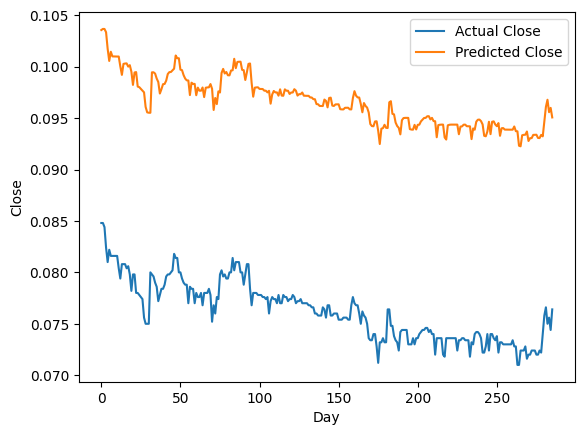

In [99]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


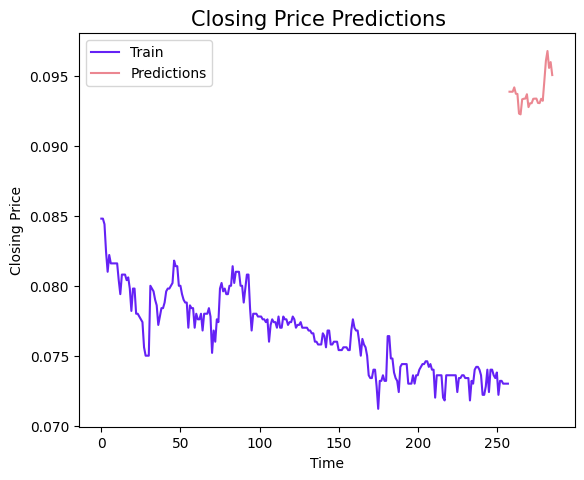

In [100]:
def plot_model_predictions(test, preds):
    plot_test = pd.DataFrame(data=test, index=range(test_predictions.size), columns=['Close'])
    plot_test['Day'] = plot_test.index
    plot_test = plot_test[:int(np.ceil(len(plot_test) * 0.9))]
    plot_pred = pd.DataFrame(data=preds, index=range(new_y_test.size), columns=['Predictions'])
    plot_pred['Day'] = plot_pred.index
    plot_pred = plot_pred[int(np.ceil(len(plot_pred) * 0.9)):]

    # fig, axes = plt.subplots(3, 2, figsize = (30, 30))
    # axes[2][1].set_visible(False)
    
    plt.suptitle('Closing Price Predictions', verticalalignment = 'top', horizontalalignment = 'center', fontsize = 15)

    # plt.facecolor('black')
    plt.plot(plot_test['Day'], plot_test['Close'], color = '#6522F5', label = 'Train')
    plt.plot(plot_pred['Day'], plot_pred['Predictions'], color = '#EB8791', label = 'Predictions')
    # plt.set_title('Meta', fontsize = 30)
    plt.xlabel('Time', fontsize = 10)
    plt.ylabel('Closing Price', fontsize = 10)
    # plt.xaxis.set_tick_params(labelsize = 18)
    # plt.yaxis.set_tick_params(labelsize = 18)
    plt.legend(loc = 'upper left', fontsize = 10)
    
    
    plt.subplots_adjust(top = 0.93)
    plt.show()
    
plot_model_predictions(new_y_test, test_predictions)